In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import os
import matplotlib.pyplot as plt
import numpy
import pandas
import tensorflow as tf
import seaborn

from kddcup_dataset import KDDCupDataset
from models import kdd_coembedded_lstm, kdd_embedded_lstm
from quick_experiment import utils
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import gensim

In [3]:
seaborn.set(style='white', rc={'figure.figsize':(11.7,8.27)})

In [4]:
def read_embedding_model(model_path):
    if model_path is None:
        return None
    return gensim.models.Word2Vec.load(model_path)

In [5]:
def get_outputs(model):
    sequence_output = []

    for iteration in range(5):
        feed_dict = model._fill_feed_dict('test')
        output = model.sess.run(model.state_op, feed_dict=feed_dict)
        for instance_index, (instance_output, instance, lenght, label) in enumerate(
                zip(output, feed_dict[model.instances_placeholder],
                    feed_dict[model.lengths_placeholder], feed_dict[model.labels_placeholder])):
            for time_step, (time_step_action, time_step_output) in enumerate(
                    zip(instance[:lenght], instance_output[:lenght])):
                sequence_output.append([
                    instance_index+(model.batch_size*iteration), time_step, time_step_output, time_step_action, label])

    return pandas.DataFrame(data=sequence_output, columns=['student', 'time_step', 'output', 'action', 'label'])

In [6]:
def graphic_students(vectors, student_ids, xcol='pca1', ycol='pca2', action_vectors=None, lines=True, annotate=False):
    for student in student_ids:
        student_sequence = vectors[vectors.student == student]
        if action_vectors is not None:
            used_actions = [int(x) for x in student_sequence.action.unique()]
            plt.scatter(action_vectors[used_actions,0], action_vectors[used_actions,1], marker='*',
                        c='black', s=200)
            for action_id in used_actions:
                plt.annotate(str(action_id), action_vectors[action_id])
        label = student_sequence.label.max()
        ax = plt.scatter(student_sequence[xcol].values, student_sequence[ycol].values, cmap='cool',
                         c=student_sequence.time_step.values, marker='x' if label == 1 else '.')
        if lines:
            plt.plot(student_sequence[xcol].values, student_sequence[ycol].values, lw=1)
        if annotate:
            for (action, x, y) in zip(student_sequence.action.values, 
                                      student_sequence[xcol].values, student_sequence[ycol].values):
                plt.annotate(str(int(action)), (x, y))
    plt.colorbar(label="Time")
    seaborn.despine()

# Full history models

In [7]:
course = 21
dataset_file = '../../data/kddcup2015/sequences/merged/c{}.p'.format(course)
embedding_file = '/home/mteruel/edm/data/kddcup2015/embeddings/word2vec/len_ge_5/c{}_20_merged_embeddings.model'.format(course)

embedding_model = read_embedding_model(embedding_file)
# embedding_model = None
dataset_config = {'train': 0.85, 'test': 1, 'validation': 0.15}
train_sequences, test_sequences, train_labels, test_labels = utils.pickle_from_file(dataset_file) 

kddcup_dataset = KDDCupDataset(embedding_model=embedding_model)
kddcup_dataset.create_fixed_samples(
    numpy.array([x[:,0] for x in train_sequences]), train_labels,
    numpy.array([x[:,0] for x in test_sequences]), test_labels,
    partition_sizes=dataset_config, samples_num=1)

kddcup_dataset.set_current_sample(0)

In [9]:
experiment_config = {
    'batch_size': 50,
    'hidden_layer_size': 50,
    'embedding_size': 20,
    'max_num_steps': 200,
    'dropout_ratio': 0.3,
    'embedding_model': embedding_model,
    'log_values': 50,
    'finetune_embeddings': False
}

# model_dirname = '../../results/kddcup/coembedding/pretrained/tensorboard/18-01-26-20-05/c{}_run0/square'.format(course)
# model_dirname = '../../results/kddcup/coembedding/tensorboard/18-01-22-18-57/c{}_run0/square'.format(course)
model_dirname = '../../results/kddcup/embedding/aied_results/pretrained/tensorboard/18-01-27-22-16/c{}_run0/elstm'.format(course)
model_filename = os.path.join(model_dirname, 'model.ckpt-0')

tf.reset_default_graph()
# model = kdd_coembedded_lstm.KDDCupCoEmbeddedLSTMModel(
#     kddcup_dataset, logs_dirname=model_dirname, **experiment_config)
model = kdd_embedded_lstm.KDDCupEmbeddedLSTMModel(
    kddcup_dataset, logs_dirname=model_dirname, **experiment_config)

model.build_all()

model.load(model_filename)

NotFoundError: Key recurrent_layer//basic_lstm_cell/kernel/Adam_1 not found in checkpoint
	 [[Node: save/RestoreV2_15 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_15/tensor_names, save/RestoreV2_15/shape_and_slices)]]

Caused by op 'save/RestoreV2_15', defined at:
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-2d3888976b3d>", line 23, in <module>
    model.build_all()
  File "../models/kdd_embedded_lstm.py", line 112, in build_all
    super(KDDCupEmbeddedLSTMModel, self).build_all()
  File "../quick_experiment/models/mlp.py", line 186, in build_all
    self.saver = tf.train.Saver()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key recurrent_layer//basic_lstm_cell/kernel/Adam_1 not found in checkpoint
	 [[Node: save/RestoreV2_15 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_15/tensor_names, save/RestoreV2_15/shape_and_slices)]]


In [178]:
vectors = get_outputs(model)
vectors.loc[:, 'Label'] = vectors.label.replace(
    to_replace=0, value='No Dropout').replace(to_replace=1, value='Dropout')
vectors.shape

(14356, 6)

In [179]:
vectors.groupby('student').max()['Label'].reset_index().groupby('Label').count()

student
Label              
Dropout         190
No Dropout       60

In [180]:
action_embeddings = model.sess.run(model.embedding_var)

In [181]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numpy.vstack(vectors.output.values))

vectors['pca1'] = pca_result[:,0]
vectors['pca2'] = pca_result[:,1] 
# vectors['pca3'] = pca_result[:,2]

In [182]:
actions_pca = pca.transform(action_embeddings)

ValueError: operands could not be broadcast together with shapes (196,20) (50,) 

In [183]:
vectors[:10]

student  time_step                                             output  \
0        0          0  [-0.0328118, 0.0223231, -0.019463, -0.115137, ...   
1        0          1  [-0.0469449, 0.0197979, 0.0632557, -0.135599, ...   
2        0          2  [-0.0600818, 0.0438944, 0.0396145, -0.101468, ...   
3        0          3  [-0.0726773, 0.0322917, 0.0961649, -0.0467536,...   
4        0          4  [-0.0460907, 0.0261648, 0.130456, 0.0177297, -...   
5        0          5  [-0.028935, 0.0254433, 0.15613, 0.0687605, -0....   
6        0          6  [-0.0133516, 0.027612, 0.173845, 0.112588, 0.0...   
7        0          7  [-0.02003, 0.0394782, 0.189431, 0.143961, -0.0...   
8        0          8  [-0.0361666, 0.0507483, 0.145277, 0.178193, 0....   
9        0          9  [-0.0342474, 0.0430653, 0.106649, 0.183283, 0....   

   action  label       Label      pca1      pca2  
0    10.0      0  No Dropout -0.452784 -0.514754  
1     2.0      0  No Dropout -0.642301 -0.274401  
2    10.0      0  No Dropout -0.957335 -0.291489  
3     2.0      0  No Dropout -1.026239 -0.095818  
4     1.0      0  No Dropout -1.029033  0.007518  
5     1.0      0  No Dropout -1.027029  0.112282  
6     1.0      0  No Dropout -1.020657  0.207488  
7     2.0      0  No Dropout -1.088620  0.347222  
8     8.0      0  No Dropout -1.102612  0.351345  
9    61.0      0  No Dropout -1.093316  0.423994

In [184]:
def plot_action_transition(vectors, actions=1, xcol='pca1', ycol='pca2', arrow_limit=20):
    colnames = [xcol, ycol, 'label', 'time_step']
    plt.figure(figsize=(15,15))
    for plot_index, action in enumerate(
            vectors.groupby('action')['action'].count().sort_values(ascending=False).index[:actions]):
        origin_vectors = vectors[vectors.action == action][['student'] + colnames].rename(
            columns={colname: 'origin-' + colname for colname in colnames}).iloc[:arrow_limit]
        # Plot
        xaxis_origin = origin_vectors['origin-' + xcol].sort_values().values.tolist()
        yaxis_origin = origin_vectors['origin-' + ycol].sort_values().values.tolist()
        xaxis_diff = numpy.empty((origin_vectors.shape[0], origin_vectors.shape[0]))
        xaxis_diff[:] = numpy.nan
        yaxis_diff = numpy.empty((origin_vectors.shape[0], origin_vectors.shape[0]))
        yaxis_diff[:] = numpy.nan
        labels =  numpy.zeros((origin_vectors.shape[0], origin_vectors.shape[0]))
        colors = {-1: 'r', 0: 'k', 1: 'b'}

        dfs = dict(tuple(origin_vectors.groupby(['student', 'origin-time_step'])))
        dest_vectors = []
        for (student, origin_time_step), value in dfs.items():
            previous_action = vectors[(vectors.student == student) & (vectors.time_step == origin_time_step - 1)]
            origin_coord1 = xaxis_origin.index(value['origin-' + xcol].values[0])
            origin_coord2 = yaxis_origin.index(value['origin-' + ycol].values[0])
            if previous_action.shape[0] == 0:
                continue
            xaxis_diff[origin_coord1, origin_coord2] = previous_action[xcol] - value['origin-' + xcol].values[0]
            yaxis_diff[origin_coord1, origin_coord2] = previous_action[ycol] - value['origin-' + ycol].values[0]
            labels[origin_coord1, origin_coord2] = value['origin-label'].values[0] + 1
        plt.subplot((actions//2 + 1)*100 + plot_index + 1 + 20)
        plt.quiver(xaxis_origin, yaxis_origin, xaxis_diff, yaxis_diff, labels, scale=1, units='xy',
                   cmap='Set2', width=0.01, headlength=3)
        plt.xlim((xaxis_origin[0] - 0.25, xaxis_origin[-1] + 0.25))
        plt.ylim((yaxis_origin[0] - 0.25, yaxis_origin[-1] + 0.25))
    plt.show()


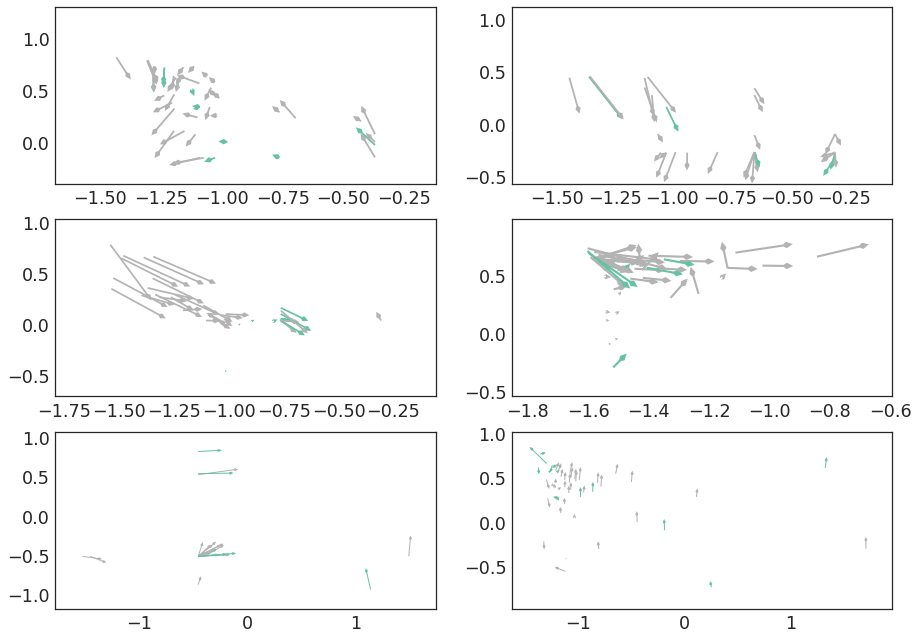

In [185]:
plot_action_transition(vectors, actions=6, arrow_limit=50)

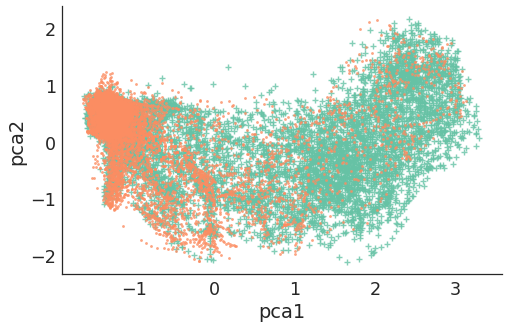

In [167]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='label', legend=False,
               fit_reg=False, size=5, aspect=1.5, palette='Set2', markers=['+', '.'])

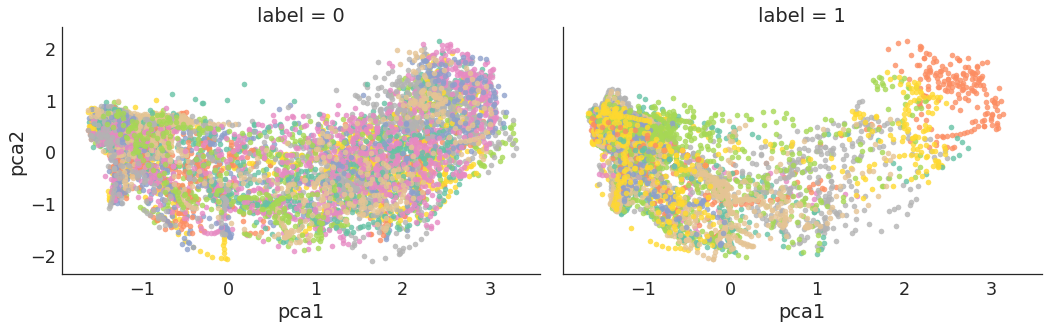

In [168]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

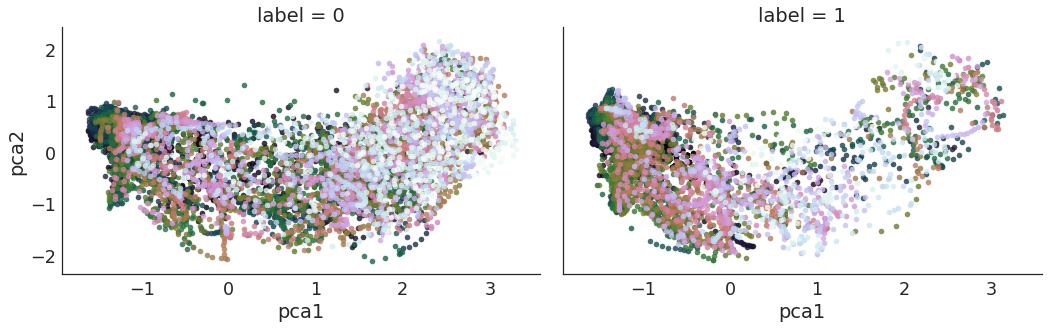

In [169]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

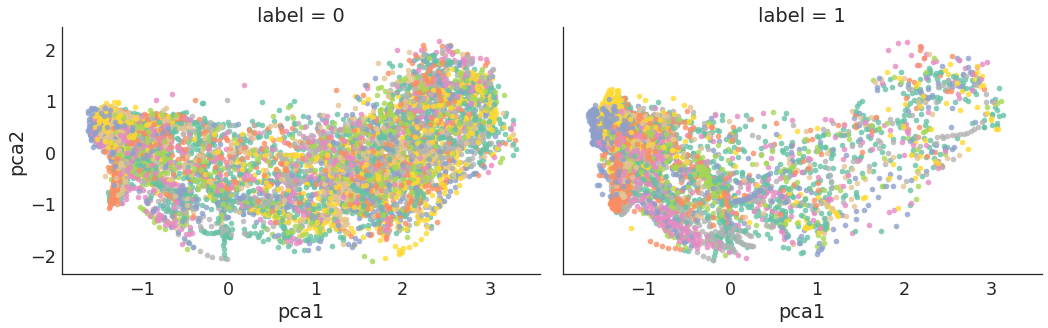

In [170]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

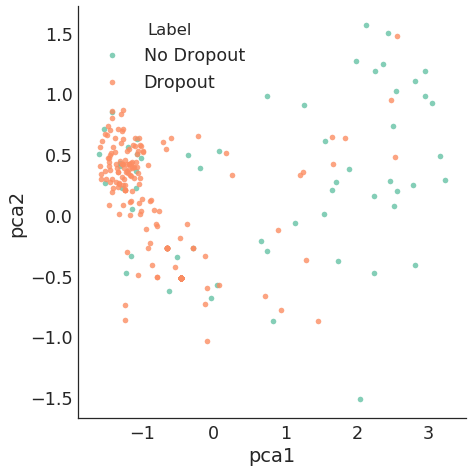

In [171]:
seaborn.set_context("paper", font_scale=2.2)
seaborn.lmplot(data=vectors.groupby('student').last(), x='pca1', y='pca2', hue='Label',
               fit_reg=False, size=7, palette='Set2', legend_out=False)

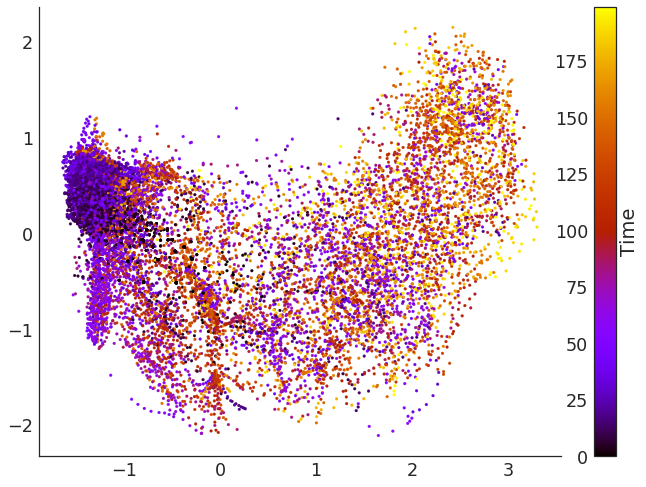

In [172]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.pca1.values, vectors.pca2.values, c=vectors.time_step.values, marker='.', cmap='gnuplot')
plt.colorbar(label="Time")
# plt.scatter(actions_pca[used_actions,0], actions_pca[used_actions,1], marker='*', s=200)
# for action_id, point in enumerate(actions_pca):
#     if action_id in used_actions:
#         plt.annotate(str(action_id), point)
seaborn.despine()

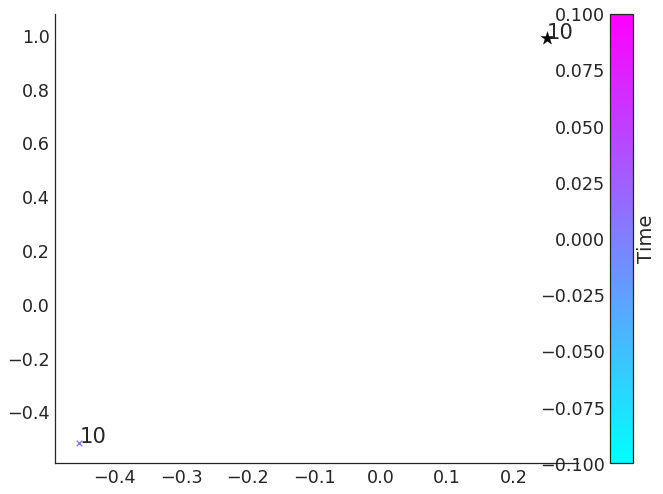

In [173]:
graphic_students(vectors, [50],  action_vectors=actions_pca, annotate=True)

In [190]:
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(numpy.vstack(vectors.output.values))

vectors['tsne1'] = tsne_results[:,0]
vectors['tsne2'] = tsne_results[:,1]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 14356 samples in 0.027s...
[t-SNE] Computed neighbors for 14356 samples in 7.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14356
[t-SNE] Computed conditional probabilities for sample 2000 / 14356
[t-SNE] Computed conditional probabilities for sample 3000 / 14356
[t-SNE] Computed conditional probabilities for sample 4000 / 14356
[t-SNE] Computed conditional probabilities for sample 5000 / 14356
[t-SNE] Computed conditional probabilities for sample 6000 / 14356
[t-SNE] Computed conditional probabilities for sample 7000 / 14356
[t-SNE] Computed conditional probabilities for sample 8000 / 14356
[t-SNE] Computed conditional probabilities for sample 9000 / 14356
[t-SNE] Computed conditional probabilities for sample 10000 / 14356
[t-SNE] Computed conditional probabilities for sample 11000 / 14356
[t-SNE] Computed conditional probabilities for sample 12000 / 14356
[t-SNE] Computed conditional probabilities for sam

In [ ]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

In [ ]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

In [ ]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

In [ ]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='label', legend=False,
               fit_reg=False, size=5, aspect=1.5, palette='Set2', markers=['+', '.'])

In [ ]:
seaborn.lmplot(data=vectors.groupby('student').last(), x='tsne1', y='tsne2', hue='label',
               fit_reg=False, size=5, aspect=1.5, palette='Set2')

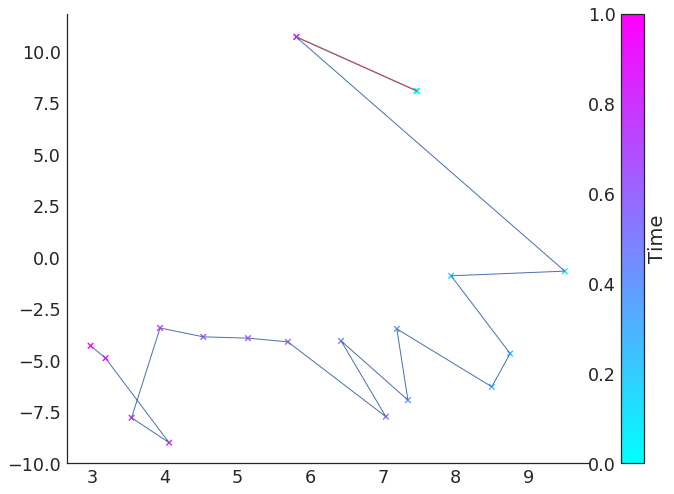

In [156]:
graphic_students(vectors, [17,14, 25], xcol='tsne1', ycol='tsne2')

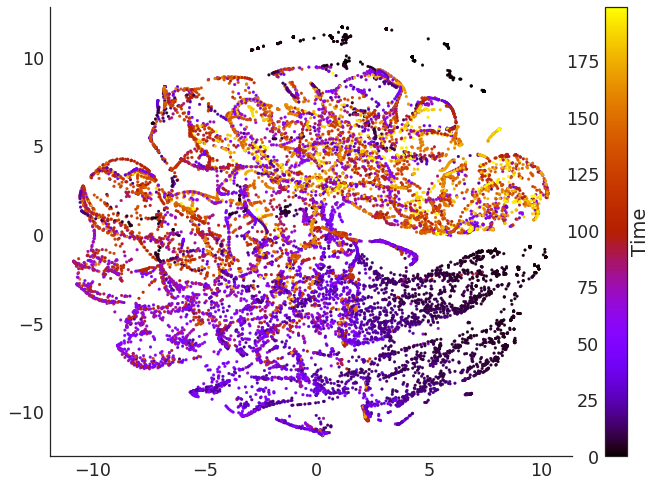

In [157]:
# used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.tsne1.values, vectors.tsne2.values, c=vectors.time_step.values, marker='.', cmap='gnuplot')
plt.colorbar(label="Time")
# plt.scatter(actions_tsne[used_actions,0], actions_tsne[used_actions,1], marker='*', s=200)
# for action_id, point in enumerate(actions_tsne):
#     if action_id in used_actions:
#         plt.annotate(str(action_id), point)
seaborn.despine()

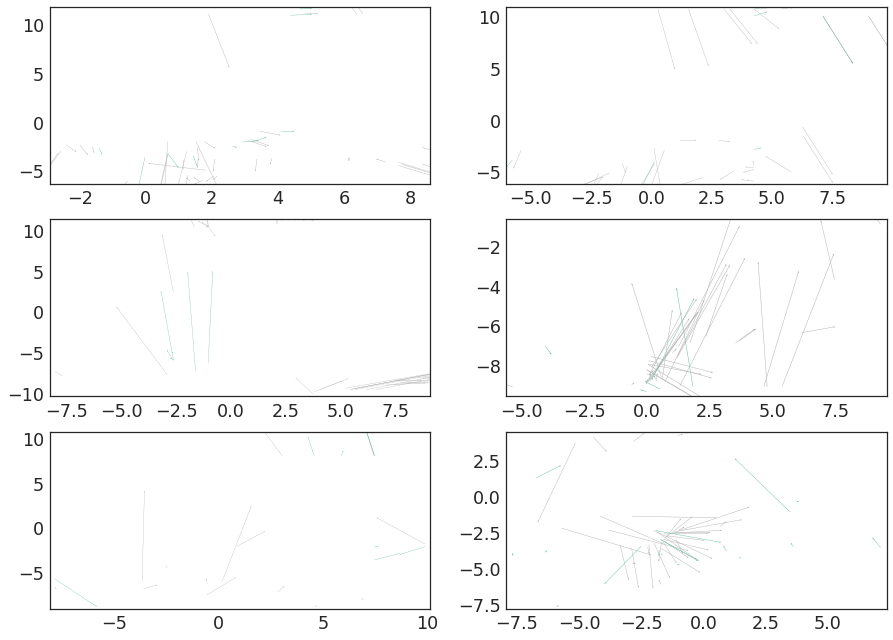

In [158]:
plot_action_transition(vectors, actions=6, arrow_limit=50, xcol='tsne1', ycol='tsne2')

---
# Period-wise models

In [89]:
course = 21
period = 0
dataset_file = '../../data/kddcup2015/early_sequences/c{}_span7_period{}_merged.p'.format(course, period)

dataset_config = {'train': 0.85, 'test': 1, 'validation': 0.15}
train_df, test_df = utils.pickle_from_file(dataset_file)

period_kddcup_dataset = KDDCupDataset(embedding_model=None)
period_kddcup_dataset.create_fixed_samples(
    numpy.array([numpy.array(x)[:,0] for x in train_df.sequence.values]), train_df.dropout.values,
    numpy.array([numpy.array(x)[:,0] for x in test_df.sequence.values]), test_df.dropout.values,
    partition_sizes=dataset_config, samples_num=1)

period_kddcup_dataset.set_current_sample(0)

In [90]:
experiment_config = {
    'batch_size': 50,
    'hidden_layer_size': 50,
    #'embedding_size': 50,
    'max_num_steps': 200,
    'dropout_ratio': 0.3,
    'embedding_model': None,
}

model_dirname = '../../results/kdd_early_dropout/coembedded/tensorboard/18-03-06-14-36/c{}_p{}_run0/norm-fixed'.format(
    course, period)
model_filename = os.path.join(model_dirname, 'model.ckpt-0')

tf.reset_default_graph()
period_model = kdd_coembedded_lstm.KDDCupCoEmbeddedLSTMModel4(
    period_kddcup_dataset, logs_dirname=model_dirname, **experiment_config)

period_model.build_all()

period_model.load(model_filename)

In [91]:
action_embeddings = period_model.sess.run(period_model.embedding_var)

In [92]:
vectors = get_outputs(period_model)

In [93]:
vectors[:5]

student  time_step                                             output  \
0        0          0  [-0.218415, -0.11835646, 0.12786283, -0.043160...   
1        0          1  [-0.31085756, -0.17837098, 0.20559812, -0.1095...   
2        0          2  [-0.35106048, -0.11561663, 0.27492625, -0.2132...   
3        0          3  [-0.35115594, -0.078101255, 0.30344337, -0.259...   
4        0          4  [-0.34977067, -0.057213787, 0.31366402, -0.279...   

   action  label  
0   302.0      1  
1   306.0      1  
2    59.0      1  
3    59.0      1  
4    59.0      1

In [94]:
vectors.groupby('student').max()['label'].reset_index().groupby('label').count()

student
label         
0           69
1          181

In [95]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numpy.vstack(vectors.output.values))

vectors['pca1'] = pca_result[:,0]
vectors['pca2'] = pca_result[:,1] 

In [96]:
actions_pca = pca.transform(action_embeddings)

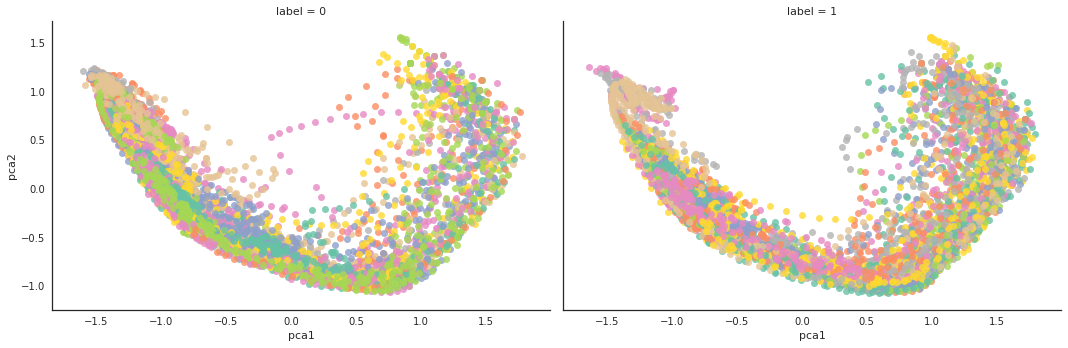

In [97]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

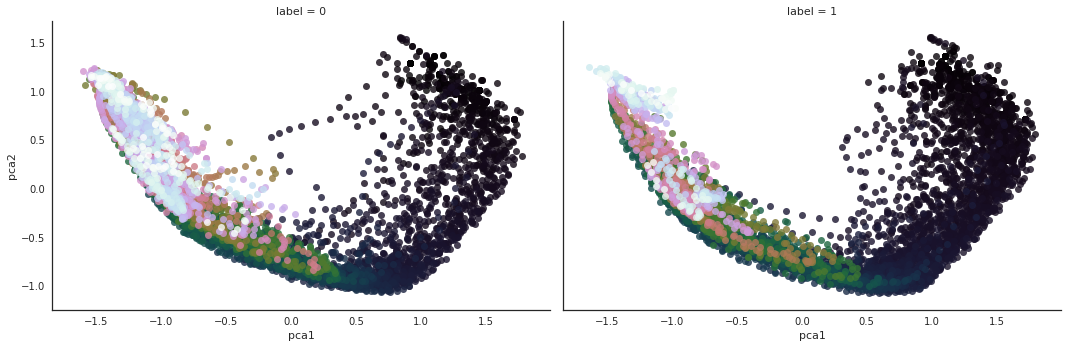

In [98]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

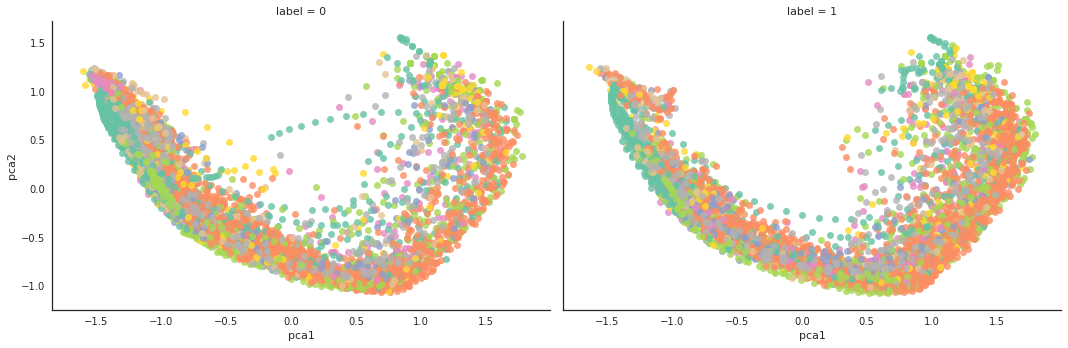

In [99]:
seaborn.lmplot(data=vectors, x='pca1', y='pca2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

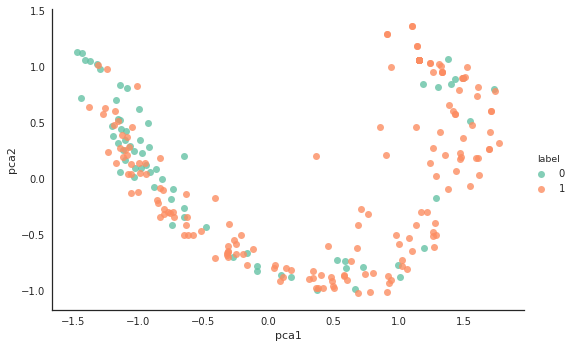

In [100]:
seaborn.lmplot(data=vectors.groupby('student').last(), x='pca1', y='pca2', hue='label',
               fit_reg=False, size=5, aspect=1.5, palette='Set2')

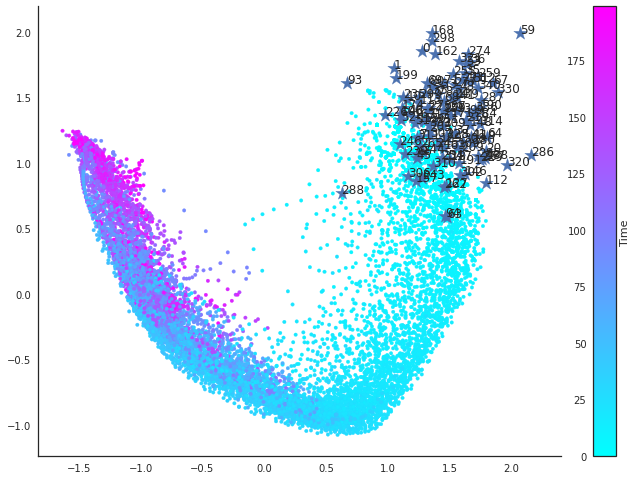

In [101]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.pca1.values, vectors.pca2.values, c=vectors.time_step.values, marker='.', cmap='cool')
plt.colorbar(label="Time")
plt.scatter(actions_pca[used_actions,0], actions_pca[used_actions,1], marker='*', s=200)
for action_id, point in enumerate(actions_pca):
    if action_id in used_actions:
        plt.annotate(str(action_id), point)
seaborn.despine()

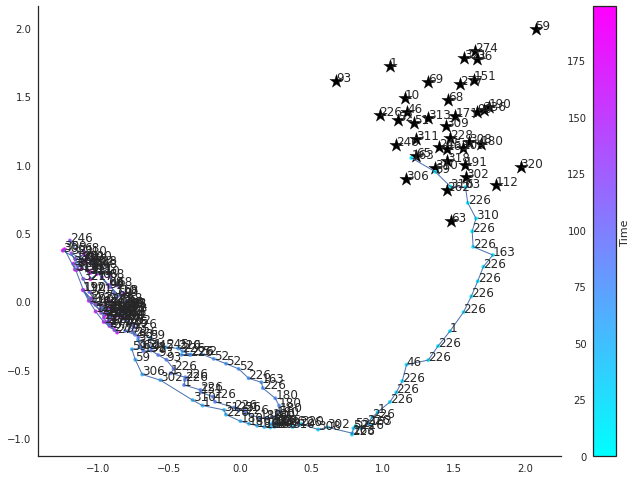

In [102]:
graphic_students(vectors, [6], annotate=True, action_vectors=actions_pca)

In [103]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(numpy.vstack([numpy.vstack(vectors.output.values), action_embeddings]))

vectors['tsne1'] = tsne_results[:vectors.shape[0],0]
vectors['tsne2'] = tsne_results[:vectors.shape[0],1]

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 13098 samples in 0.020s...
[t-SNE] Computed neighbors for 13098 samples in 2.319s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13098
[t-SNE] Computed conditional probabilities for sample 2000 / 13098
[t-SNE] Computed conditional probabilities for sample 3000 / 13098
[t-SNE] Computed conditional probabilities for sample 4000 / 13098
[t-SNE] Computed conditional probabilities for sample 5000 / 13098
[t-SNE] Computed conditional probabilities for sample 6000 / 13098
[t-SNE] Computed conditional probabilities for sample 7000 / 13098
[t-SNE] Computed conditional probabilities for sample 8000 / 13098
[t-SNE] Computed conditional probabilities for sample 9000 / 13098
[t-SNE] Computed conditional probabilities for sample 10000 / 13098
[t-SNE] Computed conditional probabilities for sample 11000 / 13098
[t-SNE] Computed conditional probabilities for sample 12000 / 13098
[t-SNE] Computed conditional probabilities for sam

In [104]:
actions_tsne = tsne_results[vectors.shape[0]:]

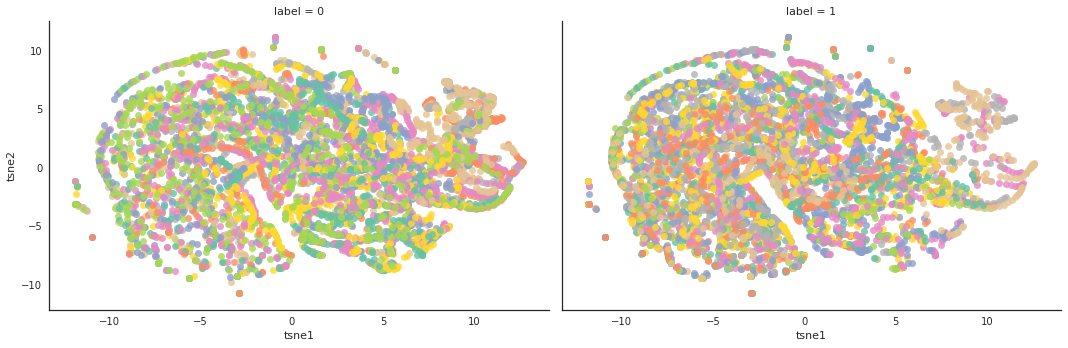

In [105]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='student', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

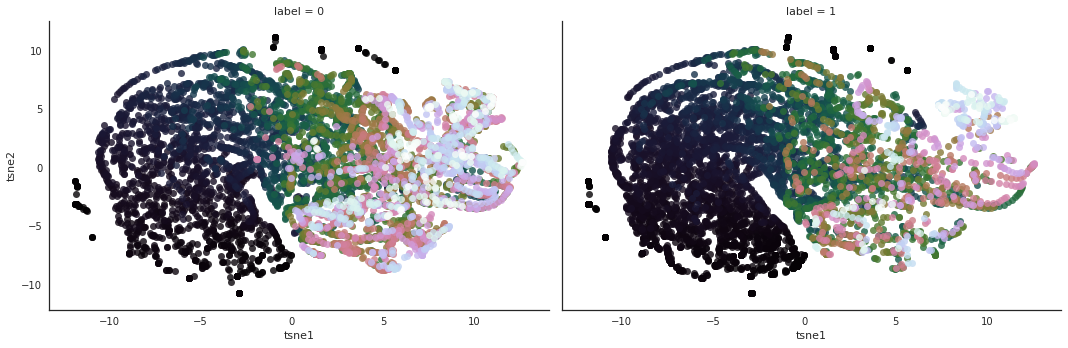

In [106]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='time_step', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='cubehelix')

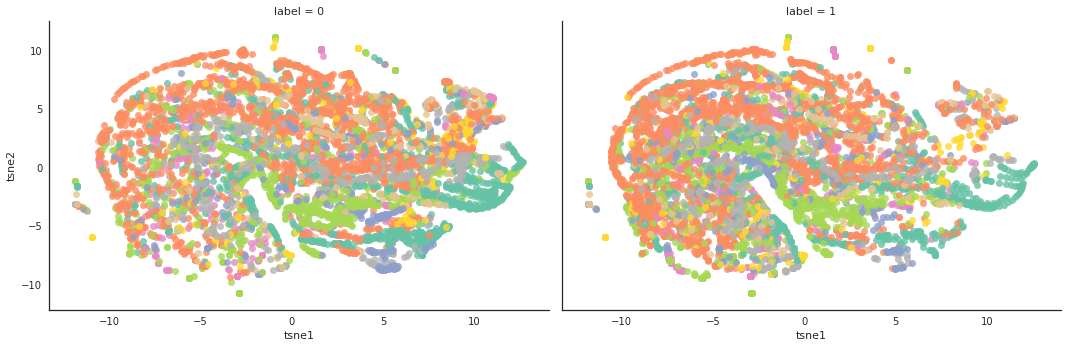

In [107]:
seaborn.lmplot(data=vectors, x='tsne1', y='tsne2', hue='action', legend=False,
               fit_reg=False, size=5, aspect=1.5, col='label', palette='Set2')

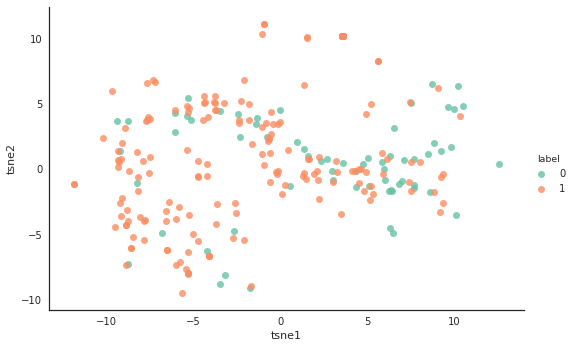

In [108]:
seaborn.lmplot(data=vectors.groupby('student').last(), x='tsne1', y='tsne2', hue='label',
               fit_reg=False, size=5, aspect=1.5, palette='Set2')

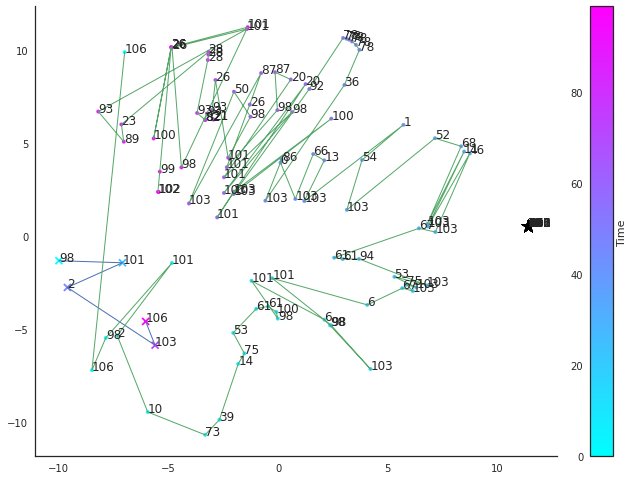

In [305]:
graphic_students(vectors, [17,14], xcol='tsne1', ycol='tsne2', annotate=True, action_vectors=actions_tsne)

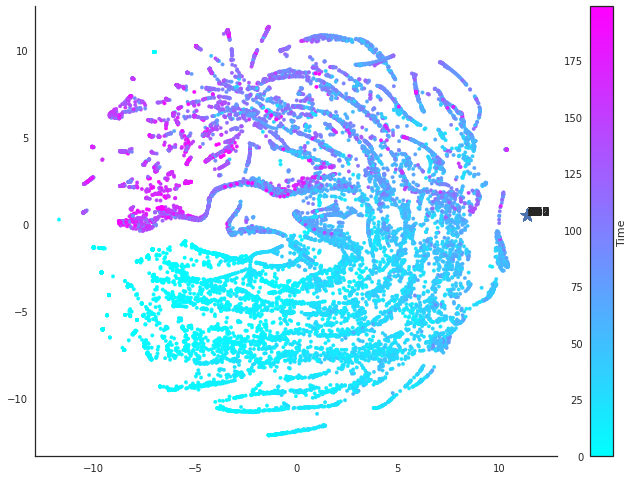

In [300]:
used_actions = [int(x) for x in vectors.action.unique()]
plt.scatter(vectors.tsne1.values, vectors.tsne2.values, c=vectors.time_step.values, marker='.', cmap='cool')
plt.colorbar(label="Time")
plt.scatter(actions_tsne[used_actions,0], actions_tsne[used_actions,1], marker='*', s=200)
for action_id, point in enumerate(actions_tsne):
    if action_id in used_actions:
        plt.annotate(str(action_id), point)
seaborn.despine()